In [1]:
import glob
import tensorflow as tf
import os, re
import numpy as np
import random

# 랜덤 시드 고정
global_seed = 2
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
seed_everything(global_seed)

# pretty sample printing
def sample_print(list1):
    for i in list1:
        print(i)

### 데이터 읽어오기

In [2]:
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*' 
txt_list = glob.glob(txt_file_path)
raw_corpus = [] 

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() 
        raw_corpus.extend(raw) 

print("데이터 크기:", len(raw_corpus))
print("Examples:")
sample_print(raw_corpus[:3])

데이터 크기: 187088
Examples:
Now I've heard there was a secret chord
That David played, and it pleased the Lord
But you don't really care for music, do you?


### 데이터 정제

특수문자를 제거하는 함수입니다.

In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>'
    return sentence

corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":":continue
    
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)

sample_print(corpus[:5])

<start> now i ve heard there was a secret chord <end>
<start> that david played , and it pleased the lord <end>
<start> but you don t really care for music , do you ? <end>
<start> it goes like this <end>
<start> the fourth , the fifth <end>


토큰화했을 때 토큰의 개수가 15개를 넘어가는 문장은 작사에 부적합하기 때문에 학습데이터에서 제외합니다. 

In [4]:
short_corpus = []
for sentence in corpus:
    splitted = sentence.split(" ")
    if len(splitted) <= 15:
        short_corpus.append(sentence)
print(f'corpus에 담긴 문장의 수: {len(corpus)}')
print(f'short_corpus에 담긴 문장의 수: {len(short_corpus)}')

corpus에 담긴 문장의 수: 175749
short_corpus에 담긴 문장의 수: 156013


In [5]:
set1 = set()
for sts in short_corpus:
    for i in sts.split():
        set1.update([i])
print('총 unique 단어수:', len(set1))

총 unique 단어수: 25662


주어진 데이터셋에 맞게 토크나이저를 생성 및 fit하고, 길이를 맞추어 패딩 처리합니다. 

In [6]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,
        filters=' ',
        oov_token='<unk>'
    )
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, tokenizer

tensor, tokenizer = tokenize(short_corpus)
tensor.shape

(156013, 15)

source는 문장 끝의 \<end> 또는 \<pad>를 한 칸 잘라내서 만듭니다. target은 문장 시작의 \<start>를 잘라내서 만듭니다.

In [7]:

src_input = tensor[:, :-1]
tgt_input = tensor[:, 1:]    

BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1

### 평가 데이터셋 분리

트레이닝 시킨 모델을 평가할 수 있도록 train 데이터셋을 train과 val으로 분할합니다.


In [8]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=global_seed)

dataset_train = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)

dataset_val = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset_val = dataset_val.shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)

### 인공지능 만들기

목표: 모델의 Embedding Size와 Hidden Size를 조절하며 10 epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계

In [9]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
                            
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        return out

embedding_size = 512
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)

In [10]:
#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, reduction='none')
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset_train, epochs=10, validation_data=dataset_val)

Epoch 1/10
487/487 [==============================] - 294s 513ms/step - loss: 3.2942 - val_loss: 2.9048
Epoch 2/10
487/487 [==============================] - 256s 525ms/step - loss: 2.7273 - val_loss: 2.6349
Epoch 3/10
487/487 [==============================] - 255s 524ms/step - loss: 2.3946 - val_loss: 2.4532
Epoch 4/10
487/487 [==============================] - 256s 525ms/step - loss: 2.0718 - val_loss: 2.3206
Epoch 5/10
487/487 [==============================] - 256s 525ms/step - loss: 1.7747 - val_loss: 2.2265
Epoch 6/10
487/487 [==============================] - 256s 525ms/step - loss: 1.5189 - val_loss: 2.1642
Epoch 7/10
487/487 [==============================] - 256s 526ms/step - loss: 1.3135 - val_loss: 2.1405
Epoch 8/10
487/487 [==============================] - 256s 526ms/step - loss: 1.1618 - val_loss: 2.1430
Epoch 9/10
487/487 [==============================] - 256s 526ms/step - loss: 1.0668 - val_loss: 2.1634
Epoch 10/10
487/487 [==============================] - 256s 526m

val_loss가 최종적으로 2.1831를 달성했습니다.

트레이닝한 모델을 작동시켜 가사 텍스트를 생성합니다.

In [11]:
def generate_text(model, tokenizer, init_sentence='<start>', max_len=20):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]
    
    while True:
        predict = model(test_tensor)
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break
        
    generated = ""
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "
        
    return generated

In [20]:
generate_text(model, tokenizer, init_sentence="<start> your", max_len=20)

'<start> your love is all i ever needed <end> '

### 회고


* 이번 프로젝트에서 어려웠던 점  
트레이닝이 오래 걸리는데 도중에 자리를 옮길 일이 생기는게 어려웠습니다. 그래서 중간부터는 Colab에서 하이퍼파라미터를 튜닝하고 결과로 알아낸 하이퍼파라미터를 아이펠 클라우드로 가져와 최종결과물을 트레이닝했습니다.
  
  
* 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점  
정규표현식을 복습하게 되었고 정규표현식의 그룹 개념을 새롭게 알게 되었습니다.
하이퍼파라미터와 random seed를 모두 일치시켰다고 생각했는데 다른 loss값이 결과로 나올때가 있었습니다. 일단은 다른 하이퍼파라미터를 조정하는게 중요하다고 생각해 넘겼는데, tensorflow로 신경망을 트레이닝할 때 고려할 random seed가 더 있는지 알아보아야겠습니다.  
같은 input sentence에도 비슷하지만 다른 결과물들을 출력할수있게 하려면 모델을 어떻게 바꿔야될지 궁금합니다.
  
  
* 루브릭 평가 지표를 맞추기 위해 시도한 것들
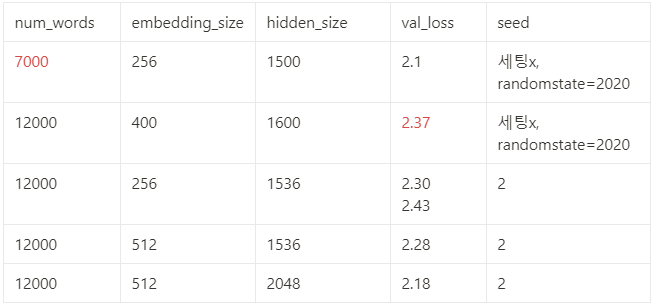  
  
  
* 자기 다짐  
앞으로 딥러닝 프로젝트를 해나가면서 바꿔볼 하이퍼파라미터들이 많아질텐데 정리하고 관리하자! 다른 사람들의 정리방법을 배우자!